In [117]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.autograd import grad
import numpy as np
from torch.nn.attention import sdpa_kernel,SDPBackend

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        # Create a matrix of shape (max_len, d_model)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        # Compute the positional encodings once in log space.
        div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float32) * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # shape: (1, max_len, d_model)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        # x shape: (batch_size, seq_len, d_model)
        seq_len = x.size(1)
        # Add positional encoding to input embeddings.
        x = x + self.pe[:, :seq_len, :]
        return x


# ----- Transformer Model (No FlashAttention) ----- #
class SimpleTransformer(nn.Module):
    def __init__(self, d_model=4, nhead=2, num_layers=1,ff=32):
        super(SimpleTransformer, self).__init__()
        self.embedding = nn.Linear(1, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_len=100)

        self.attention_layers = nn.ModuleList([
            nn.TransformerEncoderLayer(
                d_model=d_model, 
                nhead=nhead, 
                batch_first=True, 
                activation='relu', 
                norm_first=True,
                dim_feedforward=ff
            ) for _ in range(num_layers)
        ])
        self.fc_out = nn.Linear(d_model, 1)

    def forward(self, src):
        print(f"src shape: {src.shape}")  
        embedded = self.embedding(src)
        print(f"src shape: {src.shape}")  
        embedded = self.pos_encoding(embedded)
        for layer in self.attention_layers:
            embedded = layer(embedded)
        output = self.fc_out(embedded)
        return output
 #

    # Hyperparameters
vocab_size = 50
seq_len = 15
batch_size = 100
epochs = 1000
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
d_model=4
nhead=2
num_layers=1
ff=8

In [124]:
def generate_logistic_map(x0, lambd, length):
    x = [0 for _ in range(length)]
    x[0] = x0
    for i in range(1, length):
    
        x[i] = lambd * x[i-1] * (1 - x[i-1])
    return np.array(x)

class logDataset(Dataset):
    def __init__(self, num_samples=1000, seq_len=15, lambd=3.7):
        x0=np.array(np.random.uniform(0,1,num_samples))
        self.lambd=lambd
        self.data = torch.tensor(generate_logistic_map(x0,lambd,seq_len).T).to(torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]

        y = torch.tensor(generate_logistic_map(x[-1],self.lambd,2)[1])  # Copy task
        return x, y

In [106]:
dataloader=logDataset(10,2,2.9)
print(dataloader.data[0])
print(dataloader.__getitem__(0))

tensor([0.1874, 0.4415])
tensor(0.4415)
(tensor([0.1874, 0.4415]), tensor(0.7151))


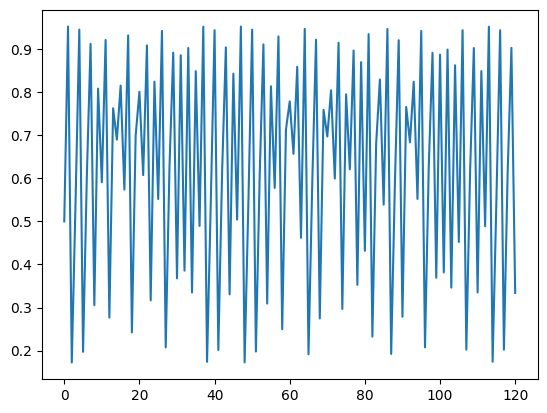

In [107]:
import numpy as np

def generate_logistic_map(x0, lambd, length):
    x = [0 for _ in range(length)]
    x[0] = x0
    for i in range(1, length):
    
        x[i] = lambd * x[i-1] * (1 - x[i-1])
    return np.array(x)

t=generate_logistic_map(.5,3.81,121)
import matplotlib.pyplot as plt
plt.plot(np.arange(len(t)),t)


In [125]:
dataset = logDataset()
testset= logDataset()
dataloader1 = DataLoader(dataset, batch_size=batch_size, shuffle=True)
dataloader2 = DataLoader(testset, batch_size=batch_size, shuffle=True)

In [126]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SimpleTransformer(d_model=16, ff=32, nhead=2, num_layers=1).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)
epochs = 2000
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for inputs, targets in dataloader1:
        inputs, targets = inputs.to(device), targets.to(device)
        print("hi")
        print(inputs)
        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = criterion(outputs.squeeze(), targets)  # MSE Loss for regression
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(dataloader)
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {avg_loss:.6f}")

hi
tensor([[0.5011, 0.9250, 0.2567,  ..., 0.6820, 0.8024, 0.5866],
        [0.5210, 0.9234, 0.2618,  ..., 0.9128, 0.2946, 0.7688],
        [0.8732, 0.4097, 0.8948,  ..., 0.5198, 0.9236, 0.2612],
        ...,
        [0.4381, 0.9108, 0.3005,  ..., 0.7184, 0.7484, 0.6966],
        [0.9187, 0.2765, 0.7401,  ..., 0.8850, 0.3766, 0.8686],
        [0.1322, 0.4244, 0.9038,  ..., 0.8048, 0.5813, 0.9005]],
       device='cuda:0')
src shape: torch.Size([100, 15])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (100x15 and 1x16)